 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/cats-and-dogs-1.ipynb#Cats-and-Dogs-(1):-Aumentando-os-dados" data-toc-modified-id="Cats-and-Dogs-(1):-Aumentando-os-dados-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (1): Aumentando os dados</a></span><ul class="toc-item"><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/cats-and-dogs-1.ipynb#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/cats-and-dogs-1.ipynb#Data-augmentation" data-toc-modified-id="Data-augmentation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data augmentation</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/cats-and-dogs-1.ipynb#Definição-do-modelo-de-treinamento" data-toc-modified-id="Definição-do-modelo-de-treinamento-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Definição do modelo de treinamento</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/cats-and-dogs-1.ipynb#Treinamento" data-toc-modified-id="Treinamento-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Treinamento</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/cats-and-dogs-1.ipynb#Treinamento-sem-aumento-de-dados" data-toc-modified-id="Treinamento-sem-aumento-de-dados-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinamento sem aumento de dados</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/cats-and-dogs-1.ipynb#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Aprendizados com este notebook</a></span></li></ul></li></ul></div>

# Cats and Dogs (1): Aumentando os dados

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Este é o primeiro de 3 experimentos que ilustram a importância da transferência de conhecimento (*transfer learning*), isto é, utilizar pesos de redes já treinadas em outras aplicações.

Utiliza-se aqui uma rede convolucional com mais de 1 milhão de parâmetros a serem treinados. O treinamento é feito de uma rede com inicialização padrão do Keras.

Este notebook ilustra a técnica de *data augmentation*.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.optim.lr_scheduler
from torch.autograd import Variable
import torchvision

from lib import pytorch_trainer as ptt

## Dataset

O dataset foi obtido de uma competição do Kaggle, https://www.kaggle.com/c/dogs-vs-cats/data.
Utilizaremos neste exemplo as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    /data/datasets/catsdogs_fewsamples/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

In [2]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, transform=None):
        self.train = train
        self.transform = transform
        if self.train:
            self.dirpath = os.path.join(rootdir, 'train')
        else:
            self.dirpath = os.path.join(rootdir, 'validation')
        print(self.dirpath)
        self.l_filepaths = [fp for fp in sorted(glob.glob(os.path.join(self.dirpath, '**'), recursive=True))
                          if fp[-4:].lower() == '.jpg']
    def __len__(self):
        return len(self.l_filepaths)
    def __getitem__(self, index):
        fp = self.l_filepaths[index]
#         out = np.float32(os.path.basename(fp)[:3].lower() == 'dog')
        out = int(os.path.basename(fp)[:3].lower() == 'dog')
        inp = PIL.Image.open(fp)
        if self.transform is not None:
            inp = self.transform(inp)
        return inp, out

## Data augmentation

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


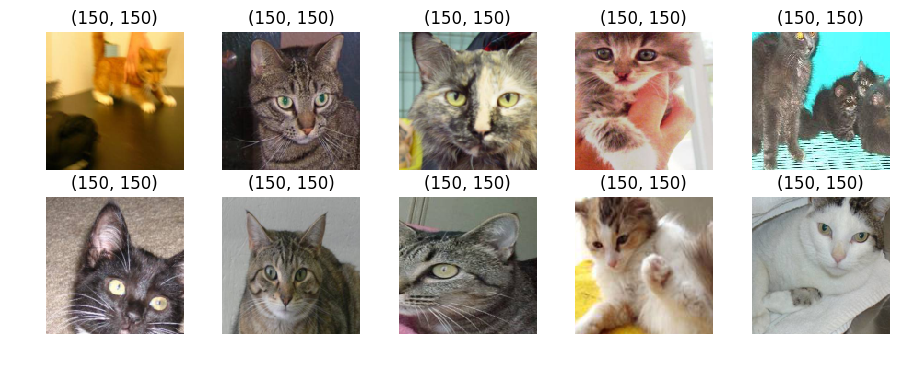

In [3]:
rootdir = '/data/datasets/catsdogs_fewsamples'
size_large = (200, 200)
size_final = (150, 150)
transf_comp_show = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_large),
                                                  torchvision.transforms.RandomCrop(size=size_final),
                                                  torchvision.transforms.RandomHorizontalFlip()])

transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_large),
                                                    torchvision.transforms.RandomCrop(size=size_final),
                                                    torchvision.transforms.RandomHorizontalFlip(),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_show = CatsDogsDataset(rootdir, train=True, transform=transf_comp_show)
dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

fig = plt.figure(figsize=(11, 4), dpi=100)
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i)
    img = dataset_show[i][0]
    ax.imshow(img)
    ax.set_title('{}'.format(img.size))
    ax.axis('off')
plt.show()

In [4]:
batch_size = 100

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

## Definição do modelo de treinamento

In [15]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.relu3 = nn.ReLU()
        self.maxp3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.dens1 = nn.Linear(in_features=64*17*17, out_features=64)
        self.relu4 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.dens2 = nn.Linear(in_features=64, out_features=2)
        self.sigm1 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxp1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxp2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxp3(x)

        x = x.view(-1, 64*17*17)
        x = self.dens1(x)
        x = self.relu4(x)
        x = self.drop1(x)
        x = self.dens2(x)
        x = self.sigm1(x)

        return x.view(-1, 2)

model = MyModel()
if torch.cuda.is_available():
    model.cuda()

## Treinamento

In [16]:
n_epochs = 50
optm = torch.optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/data_augmentation_catsdogs', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model,
                             criterion     = nn.CrossEntropyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks = [cb_chkpt, ptt.AccuracyMetric(), ptt.PrintCallback()])

train = False
if train:
    trainer.fit_loader(n_epochs, loader_train, loader_valid)
else:
    trainer.load_state('/data/models/data_augmentation_catsdogs')

Start training for 50 epochs
  1:   7.4s   T: 0.69428 0.50100   V: 0.69238 0.51125 best
  2:   7.4s   T: 0.69246 0.52250   V: 0.69095 0.50750 best
  3:   7.4s   T: 0.69101 0.51950   V: 0.68614 0.53750 best
  4:   7.4s   T: 0.68102 0.56150   V: 0.68844 0.53000 
  5:   7.4s   T: 0.67759 0.58150   V: 0.69256 0.52250 
  6:   7.4s   T: 0.67171 0.60000   V: 0.65086 0.63125 best
  7:   7.4s   T: 0.66173 0.61050   V: 0.64916 0.63625 best
  8:   7.4s   T: 0.64585 0.64300   V: 0.63093 0.64750 best
  9:   7.4s   T: 0.63871 0.64150   V: 0.62410 0.66500 best
 10:   7.4s   T: 0.63961 0.63650   V: 0.62664 0.65250 
 11:   7.4s   T: 0.61757 0.68250   V: 0.61556 0.67375 best
 12:   7.4s   T: 0.61065 0.68350   V: 0.59660 0.68750 best
 13:   7.4s   T: 0.60930 0.68900   V: 0.60043 0.68625 
 14:   7.4s   T: 0.60786 0.68700   V: 0.61680 0.67625 
 15:   7.4s   T: 0.61037 0.68100   V: 0.60879 0.68125 
 16:   7.4s   T: 0.60610 0.69000   V: 0.59400 0.70500 best
 17:   7.4s   T: 0.59861 0.69600   V: 0.61410 0.676

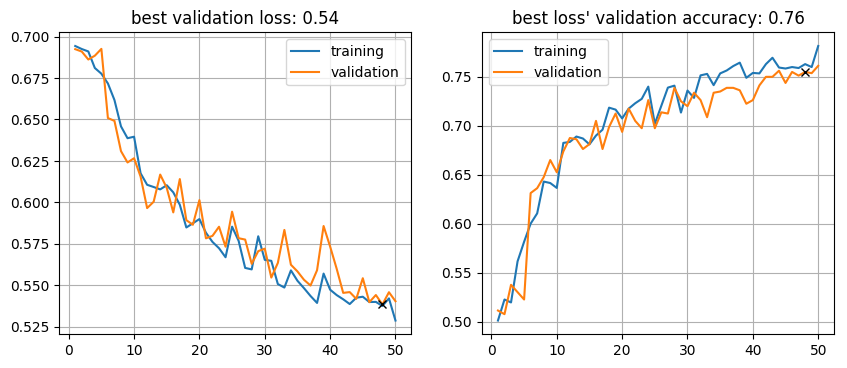

In [22]:
idx = np.argmin(trainer.metrics['valid']['losses'])
a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_subplot(1, 2, 1)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
ax.legend()
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][cb_chkpt.best_epoch-1]))
ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
ax.legend()
ax.grid(True)
plt.show()

## Treinamento sem aumento de dados

In [24]:
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

model = MyModel()
if torch.cuda.is_available():
    model.cuda()

optm = torch.optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

trainer = ptt.DeepNetTrainer(model         = model,
                             criterion     = nn.CrossEntropyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks = [ptt.AccuracyMetric(), ptt.PrintCallback()])

trainer.fit_loader(n_epochs, loader_train, loader_valid)

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation
Start training for 50 epochs
  1:   7.1s   T: 0.69699 0.51000   V: 0.69133 0.50000 best
  2:   7.1s   T: 0.69079 0.53050   V: 0.68493 0.62500 best
  3:   7.1s   T: 0.67610 0.60000   V: 0.65940 0.61000 best
  4:   7.1s   T: 0.65709 0.61850   V: 0.64223 0.64250 best
  5:   7.1s   T: 0.63476 0.66400   V: 0.63563 0.66250 best
  6:   7.1s   T: 0.61304 0.68550   V: 0.61444 0.66375 best
  7:   7.1s   T: 0.58612 0.71550   V: 0.60570 0.69000 best
  8:   7.1s   T: 0.57660 0.72350   V: 0.60130 0.69750 best
  9:   7.1s   T: 0.58045 0.72200   V: 0.60395 0.69375 
 10:   7.1s   T: 0.56802 0.73500   V: 0.61074 0.68125 
 11:   7.1s   T: 0.55705 0.74700   V: 0.61136 0.69625 
 12:   7.1s   T: 0.54869 0.75750   V: 0.60150 0.69625 
 13:   7.1s   T: 0.53200 0.77900   V: 0.60388 0.69125 
 14:   7.1s   T: 0.53244 0.77250   V: 0.60026 0.68625 best
 15:   7.1s   T: 0.52657 0.78700   V: 0.59886 0.69875 best
 16:   7.1s   T: 0.

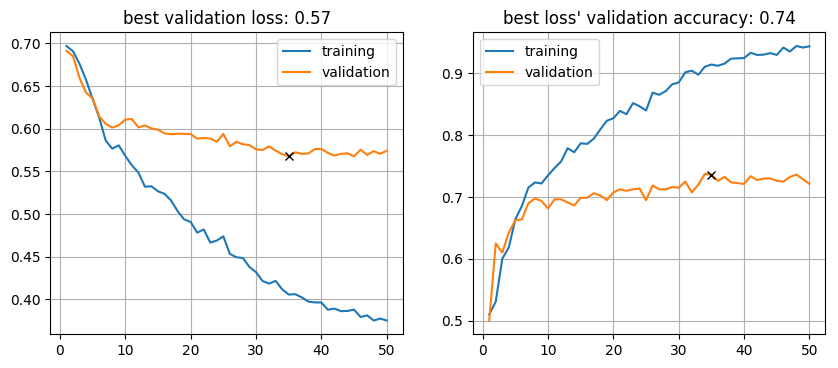

In [25]:
idx = np.argmin(trainer.metrics['valid']['losses'])
a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_subplot(1, 2, 1)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
ax.legend()
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][cb_chkpt.best_epoch-1]))
ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
ax.legend()
ax.grid(True)
plt.show()

## Aprendizados com este notebook

1. Dataset - o PyTorch possui um gerador sintético de dados onde transformações aleatórias são aplicadas no conjunto de treinamento. Esta transformação está sendo aplicada *on the fly*. É uma forma de regularização, permitindo maior generalização do classificador. O treinamento da rede com o gerador de dados resulta em um valor de accuracy nos dados de validação de 76%.
2. O treinamento desta rede sem o uso do gerador aleatório de transformações faz com que a rede sofra overfitting rapidamente, com o resultado para o conjunto de treinamento melhorando mais rapidamente, mas sem melhora para o conjunto de validação.